In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report

In [2]:
appl_filenames = ["applicationDNS.csv", "dns_application_2017_1.csv", "dns_application_2017.csv"]
appl_dataset_folder = "datasets/application_data_flow"

bot_filenames = ["init.csv","init2.csv","init3.csv","init4.csv","init5.csv"]
bot_dataset_folder = "datasets/botnet_data_flow"

In [65]:
# Loading datasets and putting 
appl_dfs = []
botnet_dfs = []
for file in appl_filenames:
    appl_dfs.append(pd.read_csv(f"{appl_dataset_folder}/{file}"))
for file in bot_filenames:
    botnet_dfs.append(pd.read_csv(f"{bot_dataset_folder}/{file}"))
    
df = pd.concat(appl_dfs+botnet_dfs, ignore_index=True)



In [66]:
d_len = 0
for d in appl_dfs:
    d_len+=len(d)
print(d_len)

d_len = 0
for d in botnet_dfs:
    d_len+=len(d)
print(d_len)

76478
1065760


In [67]:
# list of all ip addresses corresponding to the botnets
ip_list = ["192.168.50.14","192.168.50.15","192.168.50.16","192.168.50.17","192.168.50.18","192.168.50.30","192.168.50.31", "192.168.50.32","192.168.50.34"]

# label every network flow outgoing from one of the botnet's ip addresses as malicious
df['Label'] = df['Src IP'].isin(ip_list).apply(lambda x: 'Malicious' if x else 'Normal')

In [68]:
for ip in ip_list:
    entries = df[df["Src IP"]==ip]
    print(f"{ip}: {len(entries)}")

192.168.50.14: 28823
192.168.50.15: 42554
192.168.50.16: 17217
192.168.50.17: 132013
192.168.50.18: 37423
192.168.50.30: 45218
192.168.50.31: 132699
192.168.50.32: 15831
192.168.50.34: 87937


In [69]:
df.head()

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.50.50-192.168.50.88-64344-53-17,192.168.50.50,64344,192.168.50.88,53,17,13/06/2017 03:58:41 AM,3984697,1,2,...,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Normal
1,192.168.50.255-192.168.50.19-17500-17500-17,192.168.50.19,17500,192.168.50.255,17500,17,13/06/2017 03:59:59 AM,60015400,2,1,...,0,0.0,0.0,0.0,0.0,30007700.0,11807.269032,30016049.0,29999351.0,Normal
2,192.168.50.51-192.168.50.88-57092-53-17,192.168.50.51,57092,192.168.50.88,53,17,13/06/2017 03:59:46 AM,10000499,4,2,...,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Normal
3,192.168.50.51-192.168.50.88-55824-53-17,192.168.50.51,55824,192.168.50.88,53,17,13/06/2017 04:01:04 AM,7998366,4,1,...,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Normal
4,192.168.50.51-192.168.50.88-58882-53-17,192.168.50.51,58882,192.168.50.88,53,17,13/06/2017 03:59:37 AM,10000458,2,2,...,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Normal


In [70]:
# Data Preprocessing
df = df.replace(np.inf, np.nan)
df = df.dropna()

# & remove protocol with number 0 (??? TODO)
df = df[(df['Protocol'] == 6) | (df['Protocol'] == 17)]

# drop flow id and information about ip addresses as they would directly give information about origin from botnet
df_X = df.drop(columns=["Label", "Flow ID", "Src IP", "Dst IP", "Src Port", "Dst Port", "Timestamp"])
df_y = df["Label"]

In [80]:
# One hot encode the protocol column as this column represents the type of protocol (17=>UDP, 6=>TCP)

df_X = pd.get_dummies(df_X, columns=['Protocol'])
df_X

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Protocol_6,Protocol_17
0,3984697,1,2,37.0,74.0,37.0,37.0,37.0,0.0,37.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,False,True
1,60015400,2,1,268.0,134.0,134.0,134.0,134.0,0.0,134.0,...,0.0,0.0,0.0,0.0,30007700.0,11807.269032,30016049.0,29999351.0,False,True
2,10000499,4,2,168.0,84.0,42.0,42.0,42.0,0.0,42.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,False,True
3,7998366,4,1,176.0,44.0,44.0,44.0,44.0,0.0,44.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,False,True
4,10000458,2,2,88.0,88.0,44.0,44.0,44.0,0.0,44.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1142232,10000600,2,2,78.0,78.0,39.0,39.0,39.0,0.0,39.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,False,True
1142233,10000517,2,2,84.0,84.0,42.0,42.0,42.0,0.0,42.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,False,True
1142234,109001,1,1,22.0,22.0,22.0,22.0,22.0,0.0,22.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,False,True
1142235,10000651,2,2,88.0,88.0,44.0,44.0,44.0,0.0,44.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,False,True


In [82]:
# Normalize data (not for decision tree and random forest)
#df_X.columns

In [72]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3)

### Train Decision Tree

In [73]:
def train_decision_tree(X_train, X_test, y_train, y_test, depth):
    unique_labels = ["Normal", "Malicious"] #set them manually, so that confusion matrix always shows all possible labels

    dt = DecisionTreeClassifier(max_depth=depth, random_state=4)

    dt.fit(X_train, y_train)

    ##Plot and Save Decision Tree
    #plt.figure(figsize=(80, 30))
    #plot_tree(dt, filled=True,fontsize=10, feature_names=list(X_train.columns))
    #plt.savefig('decision_tree.png', bbox_inches='tight')

    #Compute train error
    y_train_pred = dt.predict(X_train)
    print(f"Train Accuracy = {accuracy_score(y_train, y_train_pred)}")
    #print(classification_report(y_train, y_train_pred, labels=unique_labels))
    
    #Compute test error and display metrics
    y_test_pred = dt.predict(X_test)
    print(f"Test Accuracy = {accuracy_score(y_test, y_test_pred)}")
    #print(classification_report(y_test, y_test_pred, labels=unique_labels))

    cm = confusion_matrix(y_test, y_test_pred, labels=unique_labels)    
    plt.figure()
    ax = sb.heatmap(cm, annot=True, cmap="Blues", fmt='d')
    ax.set_title("Test Confusion Matrix\n\n")
    ax.set_xlabel("\nPredicted Values")
    ax.set_ylabel("Actual Values ")
    ax.xaxis.set_ticklabels(unique_labels)
    ax.yaxis.set_ticklabels(unique_labels)
    plt.show()

In [84]:
# Cross-Validation

clf = DecisionTreeClassifier(max_depth=15, random_state=4)

scores = cross_val_score(clf, df_X, df_y, cv=5)

scores

array([0.89575416, 0.98649874, 0.95995188, 0.93167807, 0.95128975])

Train Accuracy = 0.8605558549902749
Test Accuracy = 0.8596381443048434


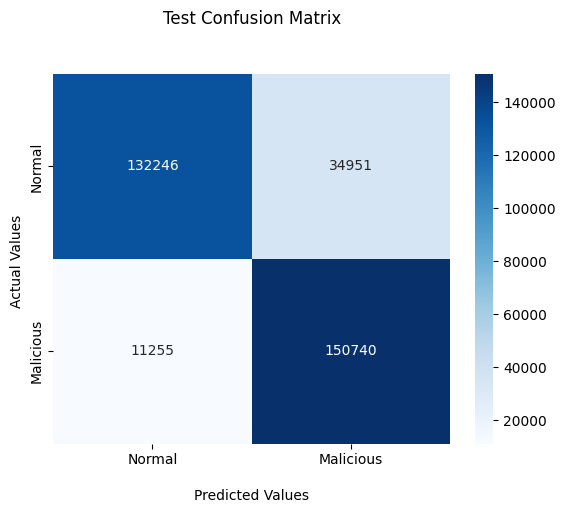

Train Accuracy = 0.9607415045162567
Test Accuracy = 0.9574442878320251


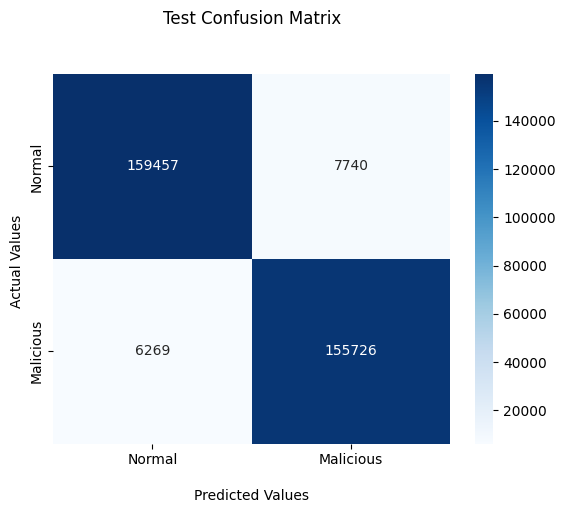

Train Accuracy = 0.9800120815399798
Test Accuracy = 0.951605749835962


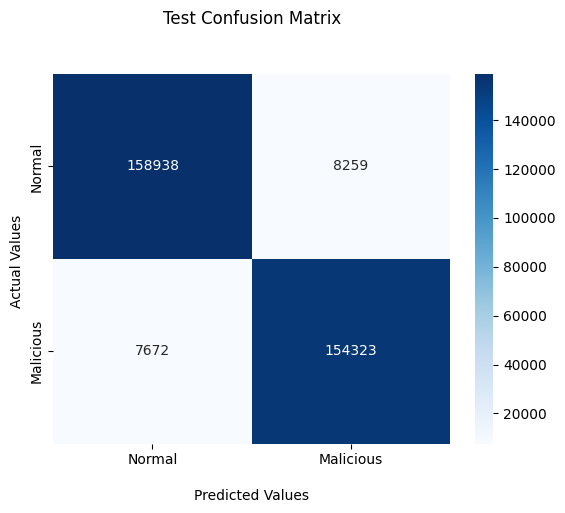

In [74]:
for depth in [5,15,30]:
    train_decision_tree(X_train, X_test, y_train, y_test, depth)

### Train Random Forest

In [75]:
def train_random_forest(X_train, X_test, y_train, y_test, depth, est):
    unique_labels = ["Normal", "Malicious"] #set them manually, so that confusion matrix always shows all possible labels

    dt = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=42)

    dt.fit(X_train, y_train)

    ##Plot and Save Decision Tree
    #plt.figure(figsize=(80, 30))
    #plot_tree(dt, filled=True,fontsize=10, feature_names=list(X_train.columns))
    #plt.savefig('decision_tree.png', bbox_inches='tight')

    #Compute train error
    y_train_pred = dt.predict(X_train)
    print(f"Train Accuracy = {accuracy_score(y_train, y_train_pred)}")
    #print(classification_report(y_train, y_train_pred, labels=unique_labels))
    
    #Compute test error and display metrics
    y_test_pred = dt.predict(X_test)
    print(f"Test Accuracy = {accuracy_score(y_test, y_test_pred)}")
    #print(classification_report(y_test, y_test_pred, labels=unique_labels))

    cm = confusion_matrix(y_test, y_test_pred, labels=unique_labels)    
    plt.figure()
    ax = sb.heatmap(cm, annot=True, cmap="Blues", fmt='d')
    ax.set_title("Test Confusion Matrix\n\n")
    ax.set_xlabel("\nPredicted Values")
    ax.set_ylabel("Actual Values ")
    ax.xaxis.set_ticklabels(unique_labels)
    ax.yaxis.set_ticklabels(unique_labels)
    plt.show()

In [76]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3)

Train Accuracy = 0.8967002293930328
Test Accuracy = 0.8973942258621108


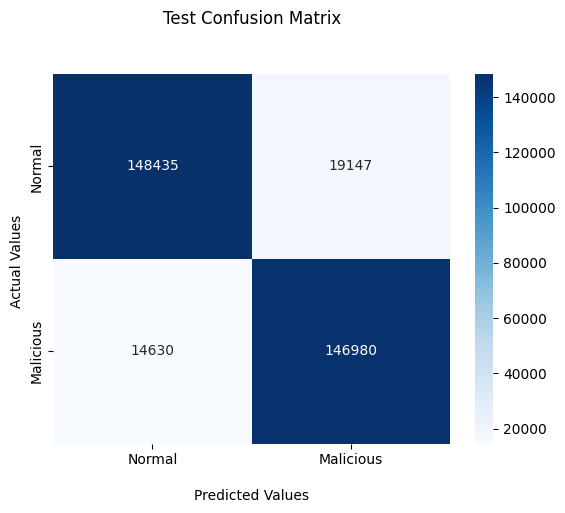

Train Accuracy = 0.9035390580044108
Test Accuracy = 0.9045784830737077


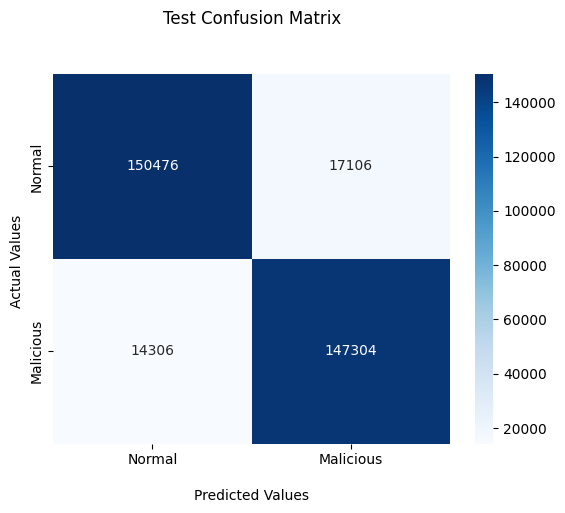

Train Accuracy = 0.9563970973058686
Test Accuracy = 0.9560833799120271


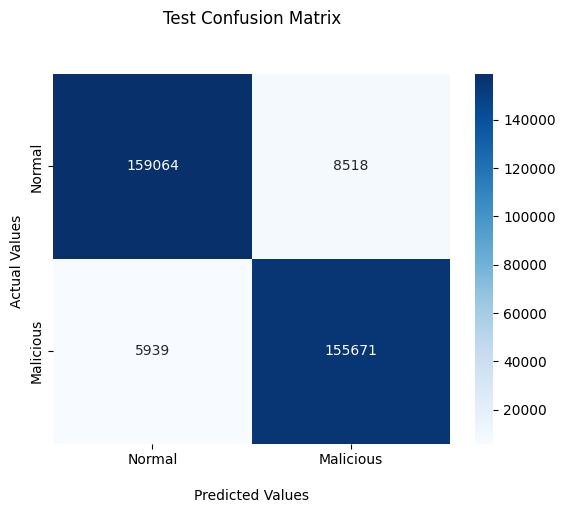

Train Accuracy = 0.9563476254826757
Test Accuracy = 0.9559436438309558


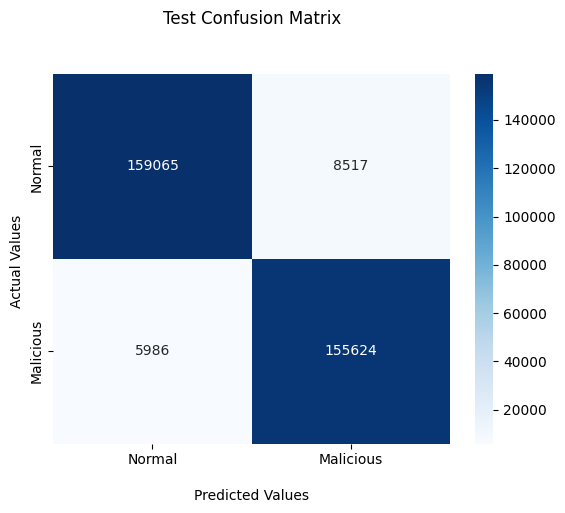

In [79]:
for depth in [5,10]:
    for est in [50,100]:
        train_random_forest(X_train, X_test, y_train, y_test, depth, est)